###Introduction to GNN

In [ ]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch_geometric
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [ ]:
def visualize_graph(G, color):
  plt.figure(figsize=(4,4))
  plt.xticks([])
  plt.yticks([])
  nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=color, cmap='Set2')
  #spring_layout: Uses a force-directed layout to place nodes naturally. (Places nodes nicely (like they’re pulled by springs))
  #cmap='Set2': Uses soft, clear colors for the nodes.
  plt.show()

In [ ]:
def visualize_embedding(h, color, epoch=None, loss=None): #h is the 2D node embeddings to be visualized. Shape: [num_nodes, embedding_dim]
  plt.figure(figsize=(4,4))
  plt.xticks([])
  plt.yticks([])
  h = h.detach().cpu().numpy()
  plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap='Set2')
  if epoch is not None and loss is not None:
    plt.xlabel(f'Epoch: {epoch}, loss: {loss.item():.4f}', forntsize=16)
  plt.show()

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print('dataset:', dataset)
print('No.of graphs:', len(dataset))
print('No.of features:', dataset.num_features)
print('No.of classes:', dataset.num_classes)

dataset: KarateClub()
No.of graphs: 1
No.of features: 34
No.of classes: 4


In [ ]:
"""only one graph in dataset"""
data = dataset[0]
print('data=', data)

print('No.of nodes', data.num_nodes)
print('No.of edges', data.num_edges)
print('Average node degree', data.num_edges/data.num_nodes)
print('No.of training nodes', data.train_mask.sum())
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

data= Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
No.of nodes 34
No.of edges 156
Average node degree 4.588235294117647
No.of training nodes tensor(4)
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


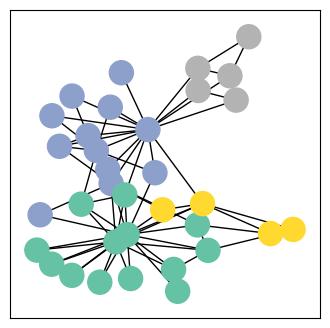

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [ ]:
#GNN

"""The GCN model takes node features (e.g., 34 nodes each with 34 features in the Karate dataset) and a graph structure (edge_index) as input.
It passes these features through three GCN layers (conv1, conv2, conv3), each performing message passing: nodes update their features
by aggregating information from their neighbors. The dimensions change from 34 → 4 → 4 → 2 across these layers,
with a tanh activation applied after each step to introduce non-linearity.
After the final GCN layer, each node has a 2D embedding capturing its structural role in the graph.
These embeddings are then passed through a final Linear layer to produce class scores for each node"""

import torch
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(123)
    self.conv1 = GCNConv(dataset.num_features, 4)
    self.conv2 = GCNConv(4,4)
    self.conv3 = GCNConv(4,2)
    self.classifier = Linear(2, dataset.num_classes)

  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    h = h.tanh()
    h = self.conv3(h, edge_index)
    h = h.tanh()
    out = self.classifier(h)

    return out, h

In [ ]:
model = GCN()
model

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)

Embedding shape: [34, 2]


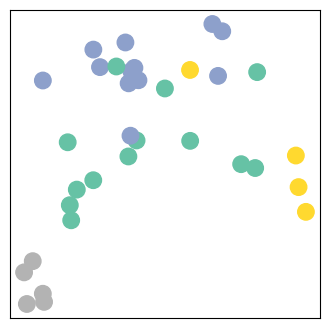

In [ ]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
def train(data):
  model.train()
  optimizer.zero_grad()  # Clear gradients.
  out, h = model(data.x, data.edge_index)  # Forward pass.
  loss = criterion(out[data.train_mask], data.y[data.train_mask].long())  # Compute loss.
  loss.backward()  # Backpropagate.
  optimizer.step()  # Update parameters.
  return loss.item(), h  # Return scalar loss


# Train loop
for epoch in range(11):
  loss, h = train(data)
  print(f'Epoch: {epoch}, Loss: {loss:.4f}')

Epoch: 0, Loss: 1.4212
Epoch: 1, Loss: 1.4199
Epoch: 2, Loss: 1.4187
Epoch: 3, Loss: 1.4175
Epoch: 4, Loss: 1.4162
Epoch: 5, Loss: 1.4150
Epoch: 6, Loss: 1.4138
Epoch: 7, Loss: 1.4126
Epoch: 8, Loss: 1.4114
Epoch: 9, Loss: 1.4102
Epoch: 10, Loss: 1.4090


###cora dataset

In [ ]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [ ]:
# Load Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [ ]:
data = dataset[0]
print(f"Data:")
print("======")
print(f"X shape: {data.x.shape}")
print(f"Y shape: {data.y.shape}")
print(f"Edge index shape: {data.edge_index.shape}")

Data:
X shape: torch.Size([2708, 1433])
Y shape: torch.Size([2708])
Edge index shape: torch.Size([2, 10556])


In [ ]:
class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_node_features, 16)
    self.conv2 = GCNConv(16, dataset.num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index)

    return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
model.train()
for epoch in range(200):
  optimizer.zero_grad()
  out = model(data)
  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()

  if epoch % 50 == 0:
    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print(f'Accuracy: {acc:.4f}')

Epoch: 0, Loss: 1.9373
Epoch: 50, Loss: 0.0304
Epoch: 100, Loss: 0.0357
Epoch: 150, Loss: 0.0277
Accuracy: 0.8150


###Cora dataset 2

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset

Cora()

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_node_features, 16)
    self.conv2 = GCNConv(16, dataset.num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index)
    return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
  optimizer.zero_grad()
  out = model(data)
  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()

In [ ]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8090


# Complete Guide to Graph Neural Networks (GNNs) - Mathematical Equations in LaTeX

## 1. Graph Representation

### Basic Graph Definition
$G = (V, E)$

### Adjacency Matrix
$A_{ij} = \begin{cases}
1 & \text{if } (i,j) \in E \\
0 & \text{otherwise}
\end{cases}$

### Node Features Matrix
$X \in \mathbb{R}^{|V| \times d}$

### Degree Matrix
$D_{ii} = \sum_{j} A_{ij}$

## 2. Graph Convolutional Networks (GCNs)

### With Self-Loops
$$\tilde{A} = A + I$$

### Normalized Adjacency Matrix
$\hat{A} = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$

### GCN Layer Forward Pass
$H^{(l+1)} = \sigma(\hat{A} H^{(l)} W^{(l)})$

### Full GCN Forward Pass
$$Z = \text{softmax}(\hat{A} \sigma(\hat{A} X W^{(0)}) W^{(1)})$$

## 3. Graph Attention Networks (GATs)

### Attention Coefficients
$$e_{ij} = a(W h_i, W h_j)$$

### Normalized Attention
$$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}$$

### Attention-based Aggregation
$$h_i' = \sigma\left(\sum_{j \in \mathcal{N}_i} \alpha_{ij} W h_j\right)$$

### Multi-head Attention
$$h_i' = \Bigg|\Bigg|_{k=1}^{K} \sigma\left(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^k W^k h_j\right)$$

### Concatenation Version
$$h_i' = \sigma\left(\frac{1}{K} \sum_{k=1}^{K} \sum_{j \in \mathcal{N}_i} \alpha_{ij}^k W^k h_j\right)$$

## 4. GraphSAGE

### Neighborhood Aggregation
$$h_{\mathcal{N}(v)} = \text{AGGREGATE}_k(\{h_{u}^{k-1}, \forall u \in \mathcal{N}(v)\})$$

### Node Representation Update
$$h_v^k = \sigma(W_k \cdot \text{CONCAT}(h_v^{k-1}, h_{\mathcal{N}(v)}))$$

### Mean Aggregator
$$h_{\mathcal{N}(v)} = \frac{1}{|\mathcal{N}(v)|} \sum_{u \in \mathcal{N}(v)} h_u^{k-1}$$

### Pooling Aggregator
$$h_{\mathcal{N}(v)} = \max_{u \in \mathcal{N}(v)} (\sigma(W_{\text{pool}} h_u + b))$$

## 5. Message Passing Neural Networks (MPNNs)

### Message Function
$$m_{v \rightarrow u}^{(t)} = M_t(h_v^{(t-1)}, h_u^{(t-1)}, e_{vu})$$

### Message Aggregation
$$m_v^{(t)} = \sum_{u \in \mathcal{N}(v)} m_{u \rightarrow v}^{(t)}$$

### Node Update
$$h_v^{(t)} = U_t(h_v^{(t-1)}, m_v^{(t)})$$

### Readout Function
$$\hat{y} = R(\{h_v^{(T)} | v \in G\})$$

## 6. Graph Isomorphism Networks (GINs)

### GIN Update Rule
$$h_v^{(l+1)} = \text{MLP}^{(l)}\left((1 + \epsilon^{(l)}) \cdot h_v^{(l)} + \sum_{u \in \mathcal{N}(v)} h_u^{(l)}\right)$$

## 7. Graph Laplacian and Spectral Methods

### Unnormalized Graph Laplacian
$$L = D - A$$

### Normalized Graph Laplacian
$$L_{\text{sym}} = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$$

### Random Walk Normalized Laplacian
$$L_{\text{rw}} = I - D^{-1} A$$

### Spectral Graph Convolution
$$g \star x = U g(\Lambda) U^T x$$

Where:
- $U$: Matrix of eigenvectors of $L$
- $\Lambda$: Diagonal matrix of eigenvalues
- $g_\theta(\Lambda)$: Filter in spectral domain

## 8. Advanced GNN Operations

### Jump Knowledge Networks
$$h_v^{(l)} = \text{CONCAT}(h_v^{(0)}, h_v^{(1)}, \ldots, h_v^{(l)})$$

### Deep Graph Infomax
$$\mathcal{L}_{\text{DGI}} = \mathbb{E}_{v \in \mathcal{V}} [\log \sigma(h_v \cdot h^{\text{global}}) + \log \sigma(-\tilde{h}_v \cdot h^{\text{global}})]$$

### Graph Autoencoder
$$\mathcal{L} = \mathcal{L}_{\text{recon}} + \mathcal{L}_{\text{prior}}$$

Where:
$$\mathcal{L}_{\text{recon}} = ||A - \sigma(Z Z^T)||_F^2$$

## 9. Pooling Operations

### Global Mean Pooling
$$h_G = \frac{1}{|V|} \sum_{v \in V} h_v$$

### Global Max Pooling
$$h_G = \max_{v \in V} h_v$$

### Sort Pooling
$$h_G = \text{SORT}(\{h_v | v \in V\})$$

### DiffPool
$$S^{(l)} = \text{softmax}(X^{(l)} W^{(l)})$$
$$X^{(l+1)} = (S^{(l)})^T X^{(l)}$$
$$A^{(l+1)} = (S^{(l)})^T A^{(l)} S^{(l)}$$

## 10. Loss Functions

### Cross-Entropy Loss (Node Classification)
$$\mathcal{L} = -\sum_{v \in V_L} \sum_{c=1}^C y_v^c \log(\hat{y}_v^c)$$

### Cross-Entropy Loss (Graph Classification)
$$\mathcal{L} = -\sum_{G \in \mathcal{G}_L} \sum_{c=1}^C y_G^c \log(\hat{y}_G^c)$$

### Link Prediction Loss
$$\mathcal{L} = -\sum_{(u,v) \in \mathcal{E}^+} \log \sigma(f(h_u, h_v)) - \sum_{(u,v) \in \mathcal{E}^-} \log(1 - \sigma(f(h_u, h_v)))$$

### Contrastive Loss
$$\mathcal{L} = \sum_{i,j} y_{ij} ||h_i - h_j||^2 + (1 - y_{ij}) \max(0, m - ||h_i - h_j||)^2$$

## 11. Regularization Techniques

### Dropout on Graphs
$$h_v^{(l)} = \frac{1}{1-p} \cdot \text{mask} \cdot h_v^{(l)}$$

### Graph Dropout
Randomly removing edges during training:
$$A'_{ij} = \begin{cases}
0 & \text{with probability } p \\
A_{ij} & \text{otherwise}
\end{cases}$$

## 12. Theoretical Bounds

### Over-smoothing Bound
$$\lim_{L \to \infty} ||h_u^{(L)} - h_v^{(L)}|| \to 0$$

### Expressive Power (1-WL Test)
Two graphs $G_1$ and $G_2$ are indistinguishable by 1-WL if:
$$\text{HASH}(G_1) = \text{HASH}(G_2)$$

### Universal Approximation
For any continuous function $f$ on graphs, there exists a GNN $\phi$ such that:
$$\sup_{G \in \mathcal{G}} |f(G) - \phi(G)| < \epsilon$$

## 13. Optimization

### Gradient Flow in GCN
$$\frac{\partial \mathcal{L}}{\partial W^{(l)}} = \frac{\partial \mathcal{L}}{\partial H^{(l+1)}} \cdot \frac{\partial H^{(l+1)}}{\partial W^{(l)}}$$

### Vanishing Gradient Analysis
$$\left\|\frac{\partial H^{(l)}}{\partial H^{(0)}}\right\| \leq \prod_{i=0}^{l-1} \|W^{(i)}\| \cdot \|\hat{A}\|$$

## 14. Attention Mechanisms

### Scaled Dot-Product Attention
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

### Multi-head Attention
$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O$$

Where:
$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

## 15. Temporal GNNs

### Recurrent GNN Update
$$h_v^{(t)} = \text{GRU}(h_v^{(t-1)}, \text{AGGREGATE}(\{h_u^{(t-1)} | u \in \mathcal{N}(v)\}))$$

### Continuous-time GNN
$$\frac{d h_v(t)}{dt} = f(h_v(t), \sum_{u \in \mathcal{N}(v)} a_{vu}(t) h_u(t))$$

